In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
tqdm.pandas()

from rdkit import RDLogger
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, rdMolTransforms
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.molSize = 300,300

from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, confusion_matrix, matthews_corrcoef
import networkx as nx

import torch
import torch.nn.functional as F
import torch_geometric
from torch_geometric.nn import SAGEConv, GCNConv, GATConv, GINConv
from torch_geometric.utils import train_test_split_edges
from torch_geometric.data import Data, Dataset, InMemoryDataset
from torch_geometric.loader import DataLoader

from torch_geometric.datasets import MoleculeNet, TUDataset
from torch_geometric.utils import to_networkx

from captum.attr import IntegratedGradients

In [2]:
def standardise_mol(mol):
    # Removing Hs, disconnect metal atoms, normalise the molecule, reionise the molecule
    clean_mol = rdMolStandardize.Cleanup(mol)
    # If more than one fragments, select parent (bigger) molecule
    parent_clean_mol = rdMolStandardize.FragmentParent(clean_mol)
    # Neutralise molecule
    uncharger = rdMolStandardize.Uncharger()
    uncharged_parent_clean_mol = uncharger.uncharge(parent_clean_mol)
    # Enumerate tautomers
    te = rdMolStandardize.TautomerEnumerator()
    taut_uncharged_parent_clean_mol = te.Canonicalize(uncharged_parent_clean_mol)
    return taut_uncharged_parent_clean_mol

def standardise_smiles(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None
        std_mol = standardise_mol(mol)
        if std_mol is None:
            return None
        else:
            return Chem.MolToSmiles(std_mol)
    except Exception as e:
        return None

def select_and_standardise(df, smiles_col='smiles', error_msg_col='error_msg', std_smiles_col='standardised_smiles', 
                           common_elements={1, 6, 7, 8, 9, 15, 16, 17, 35, 53}):
    error_msgs = []
    standardised_smiles = []

    for smiles in tqdm(df[smiles_col], desc="Processing molecules"):
        try:
            mol = Chem.MolFromSmiles(smiles)
            if mol is None:
                error_msgs.append("Invalid SMILES")
                standardised_smiles.append(None)
                continue
            invalid_element_found = False
            for atom in mol.GetAtoms():
                if atom.GetAtomicNum() not in common_elements:
                    error_msgs.append(f"Contains uncommon element: {atom.GetAtomicNum()}")
                    invalid_element_found = True
                    standardised_smiles.append(None)
                    break
            if not invalid_element_found:
                error_msgs.append('Success')
                std_smiles = standardise_smiles(smiles)
                standardised_smiles.append(std_smiles)
        except Exception as e:
            error_msgs.append(str(e))
            standardised_smiles.append(None)
    
    df[error_msg_col] = error_msgs
    df[std_smiles_col] = standardised_smiles
    return df

In [3]:
def graph_to_mol(data):
    mol = Chem.RWMol()
    node_features = data.x
    edge_indices = data.edge_index.t().numpy()
    edge_attrs = data.edge_attr.numpy()
    
    atom_indices = []
    for node_feat in node_features:
        atomic_num = int(node_feat[0].item())
        atom = Chem.Atom(atomic_num)
        idx = mol.AddAtom(atom)
        atom_indices.append(idx)
    
    for i, (start, end) in enumerate(edge_indices):
        if start < end:  #To avoid adding duplicate bonds
            bond_type = Chem.BondType.SINGLE
            if edge_attrs[i][0] == 1:
                bond_type = Chem.BondType.SINGLE
            elif edge_attrs[i][0] == 2:
                bond_type = Chem.BondType.DOUBLE
            elif edge_attrs[i][0] == 3:
                bond_type = Chem.BondType.TRIPLE
            elif edge_attrs[i][0] == 1.5:
                bond_type = Chem.BondType.AROMATIC
                
            try:
                mol.AddBond(int(start), int(end), bond_type)
            except Exception as e:
                print(f"Error adding bond between atoms {start} and {end}: {e}")

    mol = mol.GetMol()
    return mol
    
def pytorch_to_df(dataset):
    smiles_list, label_list = [], []
    for molecule in dataset:
        smiles_list.append(molecule['smiles'])
        label_list.append(molecule['y'].item())
    df = pd.DataFrame({'smiles': smiles_list, 'label': label_list})
    return df


def get_dataset_info(dataset):
    return {
        'num_graphs': len(dataset),
        'label_shape': dataset.data.y.shape,
        'num_unique_labels': len(np.unique(dataset.data.y.tolist())),
        'num_node_features': dataset.num_node_features,
        'num_edge_features': dataset.num_edge_features if hasattr(dataset.data, 'edge_attr') else 0
    }

In [4]:
## Customised preprocessing (Mols-To-Graph function)

class Graph_basic(InMemoryDataset):
    def __init__(self, dataframe, root, smiles_col='smiles', label_col='label', test=False, transform=None, pre_transform=None):
        self.test = test
        self.dataframe = dataframe
        self.smiles_col = smiles_col
        self.label_col = label_col
        self._data = None
        self.error_indices = []
        super(Graph_basic, self).__init__(root, transform, pre_transform)
        
    @property
    def raw_file_names(self):
        return 'dataframe'

    @property
    def processed_file_names(self):
        return ['data_test.pt' if self.test else 'data.pt']

    def download(self):
        pass

    def process(self):
        data_list = []
        for index, mol in tqdm(self.dataframe.iterrows(), total=self.dataframe.shape[0]):
            try:
                mol_obj = Chem.MolFromSmiles(mol[self.smiles_col])
                node_feats = self._get_node_features(mol_obj)
                edge_feats = self._get_edge_features(mol_obj)
                edge_index = self._get_adjacency_info(mol_obj)
                label = self._get_labels(mol[self.label_col])

                data = Data(x=node_feats, 
                            edge_index=edge_index,
                            edge_attr=edge_feats,
                            y=label,
                            smiles=mol[self.smiles_col])
                data_list.append(data)
            except Exception as e:
                print(f"Error processing molecule at index {index}: {e}")
                self.error_indices.append(index)

        if self.test:
            torch.save(data_list, os.path.join(self.processed_dir, 'data_test.pt'))
        else:
            torch.save(data_list, os.path.join(self.processed_dir, 'data.pt'))

    def _get_node_features(self, mol):
        """ 
        Return a matrix / 2D array of the shape [Number of Nodes, Node Feature size]
        with atomic number as the only node feature.
        """
        all_node_feats = []

        for atom in mol.GetAtoms():
            node_feats = []    
            node_feats.append(atom.GetAtomicNum())
            all_node_feats.append(node_feats)

        all_node_feats = np.asarray(all_node_feats)
        return torch.tensor(all_node_feats, dtype=torch.float)

    def _get_edge_features(self, mol):
        """ 
        Return a matrix / 2D array of the shape [Number of edges, Edge Feature size]
        with bond type as the only edge feature.
        """
        all_edge_feats = []
        
        for bond in mol.GetBonds():
            edge_feats = []
            edge_feats.append(bond.GetBondTypeAsDouble())
            all_edge_feats += [edge_feats, edge_feats]

        all_edge_feats = np.asarray(all_edge_feats)
        return torch.tensor(all_edge_feats, dtype=torch.float)

    def _get_adjacency_info(self, mol):
        edge_indices = []
        for bond in mol.GetBonds():
            i = bond.GetBeginAtomIdx()
            j = bond.GetEndAtomIdx()
            edge_indices += [[i, j], [j, i]]

        edge_indices = torch.tensor(edge_indices)
        edge_indices = edge_indices.t().to(torch.long).view(2, -1)
        return edge_indices

    def _get_labels(self, label):
        label = np.asarray([[label]])
        return torch.tensor(label, dtype=torch.int64)

    def len(self):
        return self.dataframe.shape[0]

    def get(self, idx):
        if self._data is None:
            if self.test:
                self._data = torch.load(os.path.join(self.processed_dir, 'data_test.pt'))
            else:
                self._data = torch.load(os.path.join(self.processed_dir, 'data.pt'))
        return self._data[idx]

## Customised preprocessing (Mols-To-Graph function)

class Graph_custom(InMemoryDataset):
    def __init__(self, dataframe, root, smiles_col='smiles', label_col='label', test=False, transform=None, pre_transform=None):  # modified
        self.test = test
        self.dataframe = dataframe
        self.smiles_col = smiles_col
        self.label_col = label_col
        self._data = None
        self.error_indices = []  # bad indices: To keep track of error indices
        super(Graph_custom, self).__init__(root, transform, pre_transform)
        
    @property
    def raw_file_names(self):
        """
        (The download func. is not implemented here)  
        """
        return 'dataframe'

    @property
    def processed_file_names(self):
        """ If these files are found in raw_dir, processing is skipped"""
        return ['data_test.pt' if self.test else 'data.pt']

    def download(self):
        pass

    def process(self):
        data_list = []
        for index, mol in tqdm(self.dataframe.iterrows(), total=self.dataframe.shape[0]):
            try:
                mol_obj = Chem.MolFromSmiles(mol[self.smiles_col])
                mol_obj = Chem.AddHs(mol_obj)
                AllChem.EmbedMolecule(mol_obj, randomSeed=42, 
                                      useRandomCoords = True, maxAttempts = 5000 # Use this when Bad Conformer ID error
                                     )
                AllChem.MMFFOptimizeMolecule(mol_obj)
                mol_obj = Chem.RemoveHs(mol_obj)
                AllChem.ComputeGasteigerCharges(mol_obj)
                
                ################################################################
                node_feats = self._get_node_features(mol_obj)
                edge_feats = self._get_edge_features(mol_obj)
                edge_index = self._get_adjacency_info(mol_obj)
                label = self._get_labels(mol[self.label_col])

                data = Data(x=node_feats, 
                            edge_index=edge_index,
                            edge_attr=edge_feats,
                            y=label,
                            smiles=mol[self.smiles_col]
                            ) 
                data_list.append(data)
            except Exception as e:
                print(f"Error processing molecule at index {index}: {e}")
                self.error_indices.append(index)  # bad_indices: Track the index of the molecule that caused an error

        if self.test:
            torch.save(data_list, os.path.join(self.processed_dir, 'data_test.pt'))
        else:
            torch.save(data_list, os.path.join(self.processed_dir, 'data.pt'))

    def _get_node_features(self, mol):
        """ 
        This will return a matrix / 2d array of the shape
        [Number of Nodes, Node Feature size]
        """
        all_node_feats = []

        for atom in mol.GetAtoms():
            node_feats = []
            # Feature 1: Atomic number        
            node_feats.append(atom.GetAtomicNum())
            # Feature 2: Atom degree -> Number of directly-bonded neighbours
            node_feats.append(atom.GetDegree())
            # Feature 3: Formal charge -> charge of the atom
            node_feats.append(atom.GetFormalCharge())
            # Feature 4: Hybridization -> hybridization state i.e. sp3
            node_feats.append(atom.GetHybridization())
            # Feature 5: Aromaticity
            node_feats.append(atom.GetIsAromatic())
            # Feature 6: Total Num Hs
            node_feats.append(atom.GetTotalNumHs())
            # Feature 7: Radical Electrons
            node_feats.append(atom.GetNumRadicalElectrons())
            # Feature 8: In Ring
            node_feats.append(atom.IsInRing())
            # Feature 9: Chirality
            node_feats.append(atom.GetChiralTag())

            # Feature 10: Gasteiger Charges
            node_feats.append(atom.GetDoubleProp("_GasteigerCharge"))
            # Feature 11: Total Valence
            node_feats.append(atom.GetTotalValence())
            # Feature 12: Explicit Valence
            node_feats.append(atom.GetExplicitValence())

            # Append node features to matrix
            all_node_feats.append(node_feats)

        all_node_feats = np.asarray(all_node_feats)
        return torch.tensor(all_node_feats, dtype=torch.float)

    def _get_edge_features(self, mol):
        """ 
        This will return a matrix / 2d array of the shape
        [Number of edges, Edge Feature size]
        """
        conf = mol.GetConformer() # will be used to calculate bond length, force field optimised conformer
        all_edge_feats = []
        
        for bond in mol.GetBonds():
            edge_feats = []
            # Feature 1: Bond type (as double)
            edge_feats.append(bond.GetBondTypeAsDouble())
            # Feature 2: Bond length
            edge_feats.append(np.round(rdMolTransforms.GetBondLength(conf, bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()),3))
            # Feature 3: Rings
            edge_feats.append(bond.IsInRing())
            # Append node features to matrix (twice, per direction)
            all_edge_feats += [edge_feats, edge_feats]

        all_edge_feats = np.asarray(all_edge_feats)
        return torch.tensor(all_edge_feats, dtype=torch.float)

    def _get_adjacency_info(self, mol):
        edge_indices = []
        for bond in mol.GetBonds():
            i = bond.GetBeginAtomIdx()
            j = bond.GetEndAtomIdx()
            edge_indices += [[i, j], [j, i]]

        edge_indices = torch.tensor(edge_indices)
        edge_indices = edge_indices.t().to(torch.long).view(2, -1)
        return edge_indices

    def _get_labels(self, label):
        label = np.asarray([[label]])
        return torch.tensor(label, dtype=torch.int64)

    def len(self):
        return self.dataframe.shape[0]

    def get(self, idx):
        if self._data is None: 
            if self.test:
                self._data = torch.load(os.path.join(self.processed_dir, 'data_test.pt'))
            else:
                self._data = torch.load(os.path.join(self.processed_dir, 'data.pt'))
        return self._data[idx]

#### Original code: Clintox_FDA, BBBP, BACE

In [6]:
# Pytorch benchmark datasets
hiv_dataset = MoleculeNet(root = 'TorchDataset/', name = 'HIV')
clintox_dataset = MoleculeNet(root = 'TorchDataset/', name = 'ClinTox')
bbbp_dataset = MoleculeNet(root = 'TorchDataset/', name = 'BBBP')
bace_dataset = MoleculeNet(root = 'TorchDataset/', name = 'BACE')
tu_dataset = TUDataset(root = 'TorchDataset/', name = 'MUTAG')
esol_dataset = MoleculeNet(root = 'TorchDataset/', name = 'ESOL')

In [15]:
# Get dataset info for each dataset
datasets_info = {
    'HIV': get_dataset_info(hiv_dataset),
    'ClinTox': get_dataset_info(clintox_dataset),
    'MUTAG': get_dataset_info(tu_dataset),
    'ESOL': get_dataset_info(esol_dataset),
    'BBBP': get_dataset_info(bbbp_dataset),
    'BACE': get_dataset_info(bace_dataset)
}

df_dataset_info = pd.DataFrame(datasets_info).T
df_dataset_info

/Users/ty/miniforge3/lib/python3.10/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. The data of the dataset is already cached, so any modifications to `data` will not be reflected when accessing its elements. Clearing the cache now by removing all elements in `dataset._data_list`. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


,num_graphs,label_shape,num_unique_labels,num_node_features,num_edge_features
HIV,41127,"(41127, 1)",2,9,3
ClinTox,1484,"(1484, 2)",2,9,3
MUTAG,188,"(188,)",2,7,4
ESOL,1128,"(1128, 1)",734,9,3
BBBP,2050,"(2050, 1)",2,9,3
BACE,1513,"(1513, 1)",2,9,3


#### SMILES standardisation and filter uncommon elements

In [9]:
#COMMON_ELEMENTS = {1, 6, 7, 8, 9, 15, 16, 17, 35, 53}
RDLogger.DisableLog('rdApp.*')

df_clintox = pytorch_to_df(clintox_dataset)
df_clintox = select_and_standardise(df_clintox, smiles_col='smiles', error_msg_col='error_msg', 
                       std_smiles_col='smiles_std')

df_clintox.to_csv('chem_data/clintox_standardised.csv')

Processing molecules: 100%|█████████████████| 1484/1484 [00:35<00:00, 41.56it/s]


In [11]:
df_bbbp = pytorch_to_df(bbbp_dataset)
df_bbbp = select_and_standardise(df_bbbp, smiles_col = 'smiles', error_msg_col = 'error_msg',
                                 std_smiles_col = 'smiles_std')

df_bbbp.to_csv('chem_data/bbbp_standardised.csv')

Processing molecules: 100%|████████████████| 2050/2050 [00:20<00:00, 101.69it/s]


In [12]:
df_bace = pytorch_to_df(bace_dataset)
df_bace = select_and_standardise(df_bace, smiles_col = 'smiles', error_msg_col = 'error_msg',
                                 std_smiles_col = 'smiles_std')

df_bace.to_csv('chem_data/bace_standardised.csv')

Processing molecules: 100%|████████████████| 1513/1513 [00:08<00:00, 170.97it/s]


In [11]:
## Loading preprocessed ClinTox

df_clintox = pd.read_csv('chem_data/clintox_standardised.csv', index_col = 0)
df_clintox_filtered = df_clintox[df_clintox['error_msg'] == 'Success']
print(df_clintox.shape[0], '->', df_clintox_filtered.shape[0])

1484 -> 1451


In [11]:
## Loading preprocessed BBBP

df_bbbp = pd.read_csv('chem_data/bbbp_standardised.csv', index_col = 0)
df_bbbp_filtered = df_bbbp[df_bbbp['error_msg'] == 'Success']
print(df_bbbp.shape[0], '->', df_bbbp_filtered.shape[0])

2050 -> 2020


In [12]:
## Loading preprocessed BACE

df_bace = pd.read_csv('chem_data/bace_standardised.csv', index_col = 0)
df_bace_filtered = df_bace[df_bace['error_msg'] == 'Success']
print(df_bace.shape[0], '->', df_bace_filtered.shape[0])

1513 -> 1513


#### Create custom pytorch dataset for bbbp and bace

In [13]:
RDLogger.DisableLog('rdApp.*')

In [19]:
## Prerun to make sure bad conformer ids (molecules) are identified
bbbp_cus_prerun = MoleculeDataset(dataframe=df_bbbp_filtered, smiles_col='smiles', 
                                  label_col='label', root='custom_data/bbbp/prerun/')

error_indices = bbbp_cus_prerun.error_indices  # bad_indices: Get the error indices
print(error_indices)
# df_bbbp_filtered -> got rid of uncommon elements
# df_bbbp_filtered_cleaned -> got rid of bad conformers
df_bbbp_filtered_cleaned = df_bbbp_filtered.drop(index=error_indices)  # bad_indices: Drop the error indices
df_bbbp_filtered_cleaned.to_csv('chem_data/bbbp_standardised_cleaned.csv')
print(df_bbbp_filtered.shape, df_bbbp_filtered_cleaned.shape)

Processing...
 98%|██████████████████████████████████████ | 1974/2020 [03:53<04:19,  5.65s/it]

Error processing molecule at index 1998: Bad Conformer Id


100%|███████████████████████████████████████| 2020/2020 [03:55<00:00,  8.58it/s]


[1998]
(2020, 4) (2019, 4)


Done!


In [31]:
df_bbbp_filtered_cleaned = pd.read_csv('chem_data/bbbp_standardised_cleaned.csv', index_col = 0)

bbbp_min = Graph_basic(dataframe = df_bbbp_filtered_cleaned,
                              smiles_col = 'smiles',
                             label_col = 'label',
                             root = 'custom_data/minimal_feature/bbbp_min'
                            )
bbbp_cus_2_std = Graph_custom(dataframe = df_bbbp_filtered_cleaned,
                              smiles_col = 'smiles_std',
                             label_col = 'label',
                             root = 'custom_data/bbbp/cus2_std/'
                            )
len(bbbp_cus_2_std)

2019

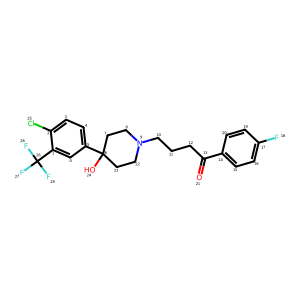

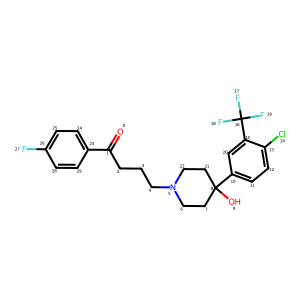

In [11]:
# Basic vs Custom molecular graphs
display(graph_to_mol(bbbp_min[1079]),
       graph_to_mol(bbbp_cus_2_std[1079]),)

In [35]:
## Prerun to make sure bad conformer ids (molecules) are identified
bace_cus_prerun = MoleculeDataset(dataframe=df_bace_filtered, smiles_col='smiles', 
                                  label_col='label', root='custom_data/bace/prerun/')

error_indices = bace_cus_prerun.error_indices  # bad_indices: Get the error indices
print(error_indices)
# df_bace_filtered -> got rid of uncommon elements
# df_bace_filtered_cleaned -> got rid of bad conformers
df_bace_filtered_cleaned = df_bace_filtered.drop(index=error_indices)  # bad_indices: Drop the error indices
df_bace_filtered_cleaned.to_csv('chem_data/bace_standardised_cleaned.csv')
print(df_bace_filtered.shape, df_bace_filtered_cleaned.shape)

Processing...
100%|███████████████████████████████████████| 1513/1513 [03:09<00:00,  7.99it/s]


[]
(1513, 4) (1513, 4)


Done!


In [36]:
df_bace_filtered_cleaned = pd.read_csv('chem_data/bace_standardised_cleaned.csv', index_col = 0)

bace_min = Graph_basic(dataframe = df_bace_filtered_cleaned,
                              smiles_col = 'smiles',
                             label_col = 'label',
                             root = 'custom_data/minimal_feature/bace_min'
                            )
bace_cus_2_std = Graph_custom(dataframe = df_bace_filtered_cleaned,
                              smiles_col = 'smiles_std',
                             label_col = 'label',
                             root = 'custom_data/bace/cus2_std/'
                            )
len(bace_cus_2_std)

Processing...
100%|███████████████████████████████████████| 1513/1513 [03:08<00:00,  8.04it/s]
Done!
Processing...
100%|███████████████████████████████████████| 1513/1513 [03:02<00:00,  8.30it/s]
Done!
/Users/ty/miniforge3/lib/python3.10/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. The given 'InMemoryDataset' only references a subset of examples of the full dataset, but 'data' will contain information of the full dataset. The data of the dataset is already cached, so any modifications to `data` will not be reflected when accessing its elements. Clearing the cache now by removing all elements in `dataset._data_list`. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  wa

1513

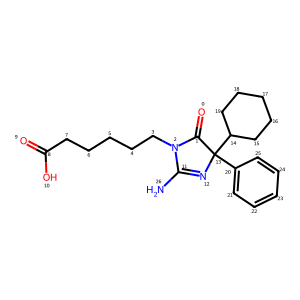

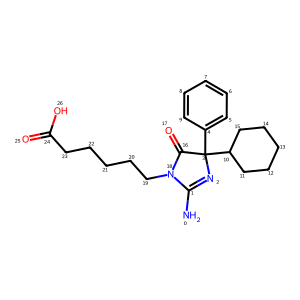

In [12]:
# Basic vs Custom molecular graphs
display(graph_to_mol(bace_min[1079]),
       graph_to_mol(bace_cus_2_std[1079]))

#### Create custom pytorch dataset for DILIst

In [6]:
# we retrieved SMILES from pubchem
# df_DILI_fail: failed to retrieve SMILES molecules, see GNN_benchmark_DILI2
RDLogger.DisableLog('rdApp.*')
df_DILI = pd.read_csv('chem_data/DILIst_smiles.csv', index_col = 0)
df_DILI_fail = df_DILI[df_DILI['smiles'].isna()]
print('fail to retrieve SMILES molecules: ',df_DILI_fail.shape[0])
df_DILI = df_DILI.dropna(subset = ['smiles'])

df_DILI = select_and_standardise(
    df = df_DILI, smiles_col = 'smiles', 
    error_msg_col = 'error_msg', std_smiles_col = 'smiles_std'
)
df_DILI.to_csv('chem_data/DILI/DILIst_standardised.csv')

fail to retrieve SMILES molecules:  78


Processing molecules: 100%|█████████████████| 1201/1201 [00:31<00:00, 38.27it/s]


In [7]:
## Loading preprocessed DILI

df_DILI = pd.read_csv('chem_data/DILI/DILIst_standardised.csv', index_col = 0)
df_DILI_filtered = df_DILI[df_DILI['error_msg'] == 'Success']
print(df_DILI.shape[0], '->', df_DILI_filtered.shape[0])

1201 -> 1167


In [8]:
dili_cus_prerun = MoleculeDataset(dataframe = df_DILI_filtered,
                              smiles_col = 'smiles',
                             label_col = 'label',
                             root = 'custom_data/DILI/prerun/'
                            )
error_indices = dili_cus_prerun.error_indices  # bad_indices: Get the error indices
print(error_indices)
# df_dili_filtered -> got rid of uncommon elements
# df_dili_filtered_cleaned -> got rid of bad conformers
df_DILI_filtered_cleaned = df_DILI_filtered.drop(index=error_indices)  # bad_indices: Drop the error indices
df_DILI_filtered_cleaned.to_csv('chem_data/DILI/DILIst_standardised_cleaned.csv')
print(df_DILI_filtered.shape, df_DILI_filtered_cleaned.shape)

Processing...
100%|███████████████████████████████████████| 1167/1167 [07:49<00:00,  2.49it/s]

[]
(1167, 7) (1167, 7)



Done!


In [9]:
df_dili_filtered_cleaned = pd.read_csv('chem_data/DILI/DILIst_standardised_cleaned.csv', index_col = 0)

dlst_cus_2_std = Graph_custom(dataframe = df_dili_filtered_cleaned,
                              smiles_col = 'smiles_std',
                             label_col = 'label',
                             root = 'custom_data/DILI/cus2_std/'
                            )

dlst_min = Graph_basic(dataframe = df_dili_filtered_cleaned,
                              smiles_col = 'smiles_std',
                             label_col = 'label',
                             root = 'custom_data/minimal_feature/dlst_min/'
                            )

#### DILIst (FDA) and DeepDILI (Li et al., 2020) data comparison

In [11]:
# we retrieved SMILES from pubchem
# df_DILI_fail: failed to retrieve SMILES molecules, see GNN_benchmark_DILI2 (GNN_benchmar_DILI)
RDLogger.DisableLog('rdApp.*')
df_DILI = pd.read_csv('chem_data/DILIst_smiles.csv', index_col = 0)
print('Number of molecules in DILIst (2020):', df_DILI.shape[0])
df_DILI_fail = df_DILI[df_DILI['smiles'].isna()]
df_DILI_fail.to_csv('chem_data/DILIst_failed_smiles.csv')
print('fail to retrieve SMILES molecules: ',df_DILI_fail.shape[0])

df_DILI = df_DILI.dropna(subset = ['smiles'])
df_DILI = select_and_standardise(
    df = df_DILI, smiles_col = 'smiles', 
    error_msg_col = 'error_msg', std_smiles_col = 'smiles_std'
)
#df_DILI.to_csv('chem_data/DILI/DILIst_standardised.csv')

Number of molecules in DILIst (2020): 1279
fail to retrieve SMILES molecules:  78


Processing molecules: 100%|████████████████████████████████████████████████████████| 1201/1201 [01:33<00:00, 12.90it/s]


In [12]:
df_DILI_filtered = df_DILI[df_DILI['error_msg'] == 'Success']
print(df_DILI.shape[0], '->', df_DILI_filtered.shape[0])

1201 -> 1167


In [3]:
## Look at result_dili.ipynb for DeepDILI and bioactive_data_training for DILI

df_deepdili_train = pd.read_excel('chem_data/DeepDILI/tx0c00374_si_004.xlsx', sheet_name = 0)
df_deepdili_test = pd.read_excel('chem_data/DeepDILI/tx0c00374_si_004.xlsx', sheet_name = 1)
print(df_deepdili_train.shape)
print(df_deepdili_test.shape)
df_deepdili = pd.concat([df_deepdili_train, df_deepdili_test], ignore_index = True)
print(df_deepdili.shape)

(753, 6)
(249, 12)
(1002, 12)


In [5]:
RDLogger.DisableLog('rdApp.*')
df_deepdili = select_and_standardise(
    df = df_deepdili, smiles_col = 'Canonical SMILES', 
    error_msg_col = 'error_msg', std_smiles_col = 'smiles_std'
)
#df_deepdili.to_csv('chem_data/DeepDILI/DeepDILI_standardised.csv')

Processing molecules: 100%|████████████████████████████████████████████████████████| 1002/1002 [00:24<00:00, 41.46it/s]


In [6]:
display(df_deepdili[df_deepdili['error_msg'] != 'Success'].head())
# Get rid of uncommon elements (filtered)
df_deepdili_filtered = df_deepdili[df_deepdili['error_msg'] == 'Success']
print(df_deepdili.shape[0], '->', df_deepdili_filtered.shape[0])

,CID,Canonical SMILES,CompoundName,initial_approval_year,DILI_label,Usage,mold2_prob_DeepDILI,mold2_class_DeepDILI,mol2vec_prob_DeepDILI,mol2vec_class_DeepDILI,maccs_prob_DeepDILI,maccs_class_DeepDILI,error_msg,smiles_std
294,16682734,O.O=C1O[Bi]Oc2ccccc12,BISMUTH SUBSALICYLATE,1954,0,training_set_1,NaN,NaN,NaN,NaN,NaN,NaN,Contains uncommon element: 83,None
583,1985,CC(=O)Nc1cc(ccc1O)[As](=O)(O)O,ACETARSOL,1964,1,training_set_1,NaN,NaN,NaN,NaN,NaN,NaN,Contains uncommon element: 33,None
776,387447,CC(C)C[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)c2cncc...,BORTEZOMIB,2003,1,test,0.54993,1.0,0.646042,1.0,0.642631,1.0,Contains uncommon element: 5,None


1002 -> 999


In [8]:
# preprocessed DILI
df_dili = pd.read_csv('chem_data/DILI/DILIst_standardised_cleaned.csv', index_col = 0)
df_dili.head()

,name,label,Routs of Administration,smiles,smiles_pcp,error_msg,smiles_std
DILIST_ID,,,,,,,
1,mercaptopurine,1,Oral,C1=NC2=C(N1)C(=S)N=CN2,C1=NC2=C(N1)C(=S)N=CN2,Success,S=c1[nH]cnc2[nH]cnc12
2,acetaminophen,1,Oral,CC(=O)NC1=CC=C(C=C1)O,CC(=O)NC1=CC=C(C=C1)O,Success,CC(=O)Nc1ccc(O)cc1
3,azathioprine,1,Oral,CN1C=NC(=C1SC2=NC=NC3=C2NC=N3)[N+](=O)[O-],CN1C=NC(=C1SC2=NC=NC3=C2NC=N3)[N+](=O)[O-],Success,Cn1cnc([N+](=O)[O-])c1Sc1ncnc2[nH]cnc12
4,chlorpheniramine,0,Oral,CN(C)CCC(C1=CC=C(C=C1)Cl)C2=CC=CC=N2,CN(C)CCC(C1=CC=C(C=C1)Cl)C2=CC=CC=N2,Success,CN(C)CCC(c1ccc(Cl)cc1)c1ccccn1
5,clofibrate,1,Oral,CCOC(=O)C(C)(C)OC1=CC=C(C=C1)Cl,CCOC(=O)C(C)(C)OC1=CC=C(C=C1)Cl,Success,CCOC(=O)C(C)(C)Oc1ccc(Cl)cc1


In [25]:
# original DILI
df_deepdili = pd.read_csv('chem_data/DeepDILI/DeepDILI_standardised.csv', index_col = 0)
df_deepdili['CompoundName'] = df_deepdili['CompoundName'].str.lower()
df_deepdili.shape

(1002, 14)

In [24]:
# molecules not present in our dataset from DeepDILI
df_deepdili[~df_deepdili['CompoundName'].isin(df_dili['name'])]

,CID,Canonical SMILES,CompoundName,initial_approval_year,DILI_label,Usage,mold2_prob_DeepDILI,mold2_class_DeepDILI,mol2vec_prob_DeepDILI,mol2vec_class_DeepDILI,maccs_prob_DeepDILI,maccs_class_DeepDILI,error_msg,smiles_std
294,16682734,O.O=C1O[Bi]Oc2ccccc12,bismuth subsalicylate,1954,0,training_set_1,NaN,NaN,NaN,NaN,NaN,NaN,Contains uncommon element: 83,NaN
409,45266800,CC1(C)S[C@@H](N[C@H]1C(=O)O)C(NC(=O)Cc2ccccc2)...,benzylpenicilloyl polylysine,1974,0,training_set_1,NaN,NaN,NaN,NaN,NaN,NaN,Success,CC1(C)S[C@H](C(NC(=O)Cc2ccccc2)C(=O)NCCCCC(N)C...
583,1985,CC(=O)Nc1cc(ccc1O)[As](=O)(O)O,acetarsol,1964,1,training_set_1,NaN,NaN,NaN,NaN,NaN,NaN,Contains uncommon element: 33,NaN
609,24846132,COC1C(O)C(O)C(OCC2OC(OC3C(O)C(O)C(C)OC3CO)C(O)...,hetastarch,1991,0,training_set_2,NaN,NaN,NaN,NaN,NaN,NaN,Success,COC1C(CO)OC(OCC2OC(OC3C(CO)OC(C)C(O)C3O)C(O)C(...
615,75905,OS(=O)(=O)c1ccc(C=C)cc1,sodium polystyrene sulfonate,1958,0,training_set_2,NaN,NaN,NaN,NaN,NaN,NaN,Success,C=Cc1ccc(S(=O)(=O)O)cc1
688,2349,CC1(C)SC2C(NC(=O)Cc3ccccc3)C(=O)N2C1C(=O)O,penicillin,1942,1,training_set_2,NaN,NaN,NaN,NaN,NaN,NaN,Success,CC1(C)SC2C(NC(=O)Cc3ccccc3)C(=O)N2C1C(=O)O
776,387447,CC(C)C[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)c2cncc...,bortezomib,2003,1,test,0.549930,1.0,0.646042,1.0,0.642631,1.0,Contains uncommon element: 5,NaN
946,4870,CN1C(CSCC(F)(F)F)Nc2cc(Cl)c(cc2S1(=O)=O)S(=O)(...,polythiazide,2005,0,test,0.928195,1.0,0.816138,1.0,0.703095,1.0,Success,CN1C(CSCC(F)(F)F)Nc2cc(Cl)c(S(N)(=O)=O)cc2S1(=...
